In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.contrib.layers import fully_connected
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
n_inputs = 784
n_hidden1 = n_inputs
n_hidden2 = n_inputs
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.00001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()


In [4]:
tf.reset_default_graph()

#autoencoder

X = tf.placeholder(tf.float32, shape = [None, n_inputs])
X_noisy = X + tf.random_normal(tf.shape(X))

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")
weights4 = tf.transpose(weights1, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")


hidden1 = activation(tf.matmul(X_noisy, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4


reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [5]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
    save_path = saver.save(sess,"./AC_ckpt")

INFO:tensorflow:Restoring parameters from ./AC_ckpt


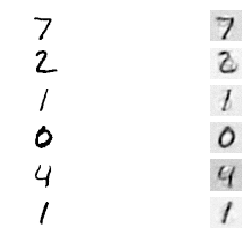

In [6]:
#Showing outputs of autoencoder

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    

n_test_digits = 6
X_test = mnist.test.images[:n_test_digits]
    
with tf.Session() as sess:
    saver.restore(sess, "./AC_ckpt")
    outputs_val = outputs.eval(feed_dict={X : X_test})
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [7]:
nodes_input = 784
nodes_hidden1 = 300
nodes_hidden2 = 150
nodes_output = 10

#Deep neural network

inputs = tf.placeholder(tf.float32, shape = (None, nodes_input), name="inputs")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.contrib.framework.arg_scope([fully_connected], activation_fn = tf.nn.relu):
    dnnhidden1 = fully_connected(inputs,nodes_hidden1)
    dnnhidden2 = fully_connected(dnnhidden1,nodes_hidden2)
    logits = fully_connected(dnnhidden2, nodes_output, activation_fn=None)
    
dnn_xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
dnn_loss = tf.reduce_mean(dnn_xentropy)

dnn_optimizer = tf.train.AdamOptimizer()
dnn_training_op = dnn_optimizer.minimize(dnn_loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(mnist.train.images, mnist.train.labels, 
                                                              test_size=0.9, random_state=42,
                                                              stratify=mnist.train.labels)

In [9]:
def next_batch(X,y,batch_size):
    n,m = X.shape
    shuffle_index = np.random.permutation(n)
    X_batch = X[shuffle_index[0:batch_size]]
    y_batch = y[shuffle_index[0:batch_size]]
    return X_batch, y_batch

In [10]:
dnn_auto_n_epochs = 100
dnn_auto_batch_size = 150

#Training Deep neual network on 10% of original data using first two hidden layers of noisy autoencoder

with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./AC_ckpt")
    for epoch in range(dnn_auto_n_epochs):
        dnn_auto_n_batches = X_train.shape[0] // dnn_auto_batch_size
        for iteration in range(dnn_auto_n_batches):
            X_batch, y_batch = next_batch(X_train,y_train, dnn_auto_batch_size)
            hidden2_eval = hidden2.eval(feed_dict={X : X_batch})
            sess.run(dnn_training_op, feed_dict={inputs: hidden2_eval, y: y_batch})            
        acc_train = accuracy.eval(feed_dict={inputs: hidden2_eval, y: y_batch})
        hidden2_eval_test = hidden2.eval(feed_dict={X : mnist.test.images})
        acc_test = accuracy.eval(feed_dict={inputs: hidden2_eval_test,y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    new_save_path = new_saver.save(sess,"./dnnAC_ckpt")

INFO:tensorflow:Restoring parameters from ./AC_ckpt
0 Train accuracy: 0.74666667 Test accuracy: 0.758
1 Train accuracy: 0.7266667 Test accuracy: 0.7871
2 Train accuracy: 0.8333333 Test accuracy: 0.8019
3 Train accuracy: 0.84 Test accuracy: 0.7977
4 Train accuracy: 0.85333335 Test accuracy: 0.8201
5 Train accuracy: 0.81333333 Test accuracy: 0.8065
6 Train accuracy: 0.79333335 Test accuracy: 0.8199
7 Train accuracy: 0.76666665 Test accuracy: 0.8236
8 Train accuracy: 0.82666665 Test accuracy: 0.8287
9 Train accuracy: 0.8666667 Test accuracy: 0.8279
10 Train accuracy: 0.84 Test accuracy: 0.833
11 Train accuracy: 0.82 Test accuracy: 0.8334
12 Train accuracy: 0.84 Test accuracy: 0.8331
13 Train accuracy: 0.82666665 Test accuracy: 0.8226
14 Train accuracy: 0.82 Test accuracy: 0.8331
15 Train accuracy: 0.86 Test accuracy: 0.8346
16 Train accuracy: 0.8066667 Test accuracy: 0.8258
17 Train accuracy: 0.8466667 Test accuracy: 0.8326
18 Train accuracy: 0.8666667 Test accuracy: 0.8345
19 Train accur